<a href="https://colab.research.google.com/github/robertchoi/BatteryDatasetImplementation/blob/master/%EA%B9%80%EC%A7%84%EA%B7%BC/GRU_%EB%AA%A8%EB%8D%B8_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import datetime
from keras.callbacks import EarlyStopping, ModelCheckpoint
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.layers import RNN, LSTM, GRU
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras import layers, models
from sklearn import preprocessing
from keras import datasets
from keras.models import load_model

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from sklearn import model_selection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0222_20110307012737_cell_7.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,7,0.296,2.25,-20
1,2011.3.7 18:29,7,0.297,2.25,-20
2,2011.3.8 6:29,7,0.298,2.25,-20
3,2011.3.8 18:29,7,0.298,2.25,-20
4,2011.3.9 6:29,7,0.296,2.25,-20
...,...,...,...,...,...
250,2011.8.30 5:28,7,0.619,2.29,-20
251,2011.8.30 17:28,7,0.620,2.30,-20
252,2011.8.31 5:28,7,0.623,2.30,-20
253,2011.8.31 16:09,7,0.639,2.30,-20


In [ ]:
df = df.drop(['CellNo', 'MeasuredDate'], axis=1)
df

,Resistance,Volt,Temp
0,0.296,2.25,-20
1,0.297,2.25,-20
2,0.298,2.25,-20
3,0.298,2.25,-20
4,0.296,2.25,-20
...,...,...,...
250,0.619,2.29,-20
251,0.620,2.30,-20
252,0.623,2.30,-20
253,0.639,2.30,-20


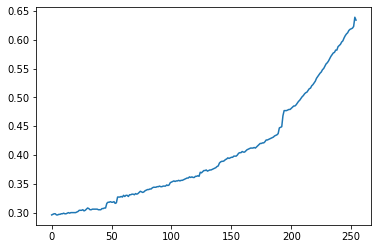

In [ ]:
df['Resistance'].plot()
train = df

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

print(df_scaled)

     Volt  Temp  Resistance
0     0.0   0.0    0.000000
1     0.0   0.0    0.002915
2     0.0   0.0    0.005831
3     0.0   0.0    0.005831
4     0.0   0.0    0.000000
..    ...   ...         ...
250   0.8   0.0    0.941691
251   1.0   0.0    0.944606
252   1.0   0.0    0.953353
253   1.0   0.0    1.000000
254   1.0   0.0    0.985423

[255 rows x 3 columns]


In [ ]:
train = df_scaled

In [ ]:
train

,Volt,Temp,Resistance
0,0.0,0.0,0.000000
1,0.0,0.0,0.002915
2,0.0,0.0,0.005831
3,0.0,0.0,0.005831
4,0.0,0.0,0.000000
...,...,...,...
250,0.8,0.0,0.941691
251,1.0,0.0,0.944606
252,1.0,0.0,0.953353
253,1.0,0.0,1.000000


train 끝



In [ ]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

train_feature = train[feature_cols]
train_label = train[label_cols]
# test_feature = test[feature_cols]
# test_label = test[label_cols]

train_feature, train_label = make_dataset(train_feature, train_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)
train_feature

# test_feature, test_label = make_dataset(test_feature, test_label, 20)
# test_feature.shape, test_label.shape

array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00291545],
        [0.        , 0.        , 0.0058309 ],
        ...,
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01166181]],

       [[0.        , 0.        , 0.00291545],
        [0.        , 0.        , 0.0058309 ],
        [0.        , 0.        , 0.0058309 ],
        ...,
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01166181]],

       [[0.        , 0.        , 0.0058309 ],
        [0.        , 0.        , 0.0058309 ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01166181],
        [0.        , 0.        , 0.01457726]],

       ...,

       [[0.6       , 0.        , 0.79008746],
        [0.6       , 0.        , 0.80174927],
        [0.6       , 0

LSTM 모델


In [ ]:


model = Sequential()
model.add(GRU(10, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join('C:/Users/wlsrm/data', 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

h = model.fit(x_train, y_train, 
                    epochs=1000, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid))

Epoch 1/1000
12/12 [==============================] - 2s 57ms/step - loss: 0.1670 - mse: 0.1670 - val_loss: 0.1446 - val_mse: 0.1446
Epoch 2/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.1453 - mse: 0.1453 - val_loss: 0.1081 - val_mse: 0.1081
Epoch 3/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.1012 - mse: 0.1012 - val_loss: 0.0825 - val_mse: 0.0825
Epoch 4/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0863 - mse: 0.0863 - val_loss: 0.0643 - val_mse: 0.0643
Epoch 5/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0583 - mse: 0.0583 - val_loss: 0.0515 - val_mse: 0.0515
Epoch 6/1000
12/12 [==============================] - 0s 10ms/step - loss: 0.0344 - mse: 0.0344 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 7/1000
12/12 [==============================] - 0s 11ms/step - loss: 0.0419 - mse: 0.0419 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 8/1000
12/12 [==============================] - 0s 11ms/step - 

In [ ]:
print(h.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


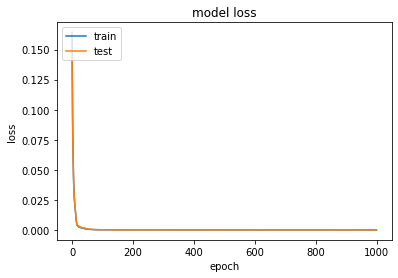

In [ ]:
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

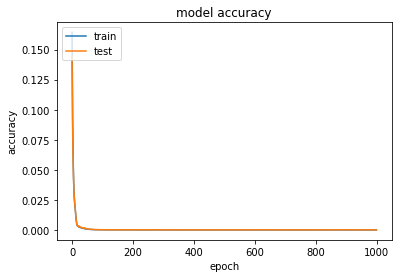

In [ ]:
plt.plot(h.history['mse'])
plt.plot(h.history['val_mse'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')
test_df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,3,0.298,2.23,-20
1,2011.3.7 18:29,3,0.298,2.23,-20
2,2011.3.8 6:29,3,0.297,2.24,-20
3,2011.3.8 18:29,3,0.299,2.23,-20
4,2011.3.9 6:29,3,0.298,2.24,-20
...,...,...,...,...,...
253,2011.8.30 5:28,3,0.316,2.25,-20
254,2011.8.30 17:28,3,0.316,2.25,-20
255,2011.8.31 5:28,3,0.315,2.25,-20
256,2011.8.31 16:09,3,0.318,2.25,-20


In [ ]:
test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)
test_df

,Resistance,Volt,Temp
0,0.298,2.23,-20
1,0.298,2.23,-20
2,0.297,2.24,-20
3,0.299,2.23,-20
4,0.298,2.24,-20
...,...,...,...
253,0.316,2.25,-20
254,0.316,2.25,-20
255,0.315,2.25,-20
256,0.318,2.25,-20


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

print(test_df_scaled)

         Volt  Temp  Resistance
0    0.333333   0.0    0.047619
1    0.333333   0.0    0.047619
2    0.666667   0.0    0.000000
3    0.333333   0.0    0.095238
4    0.666667   0.0    0.047619
..        ...   ...         ...
253  1.000000   0.0    0.904762
254  1.000000   0.0    0.904762
255  1.000000   0.0    0.857143
256  1.000000   0.0    1.000000
257  1.000000   0.0    0.904762

[258 rows x 3 columns]


In [ ]:
test = test_df_scaled

In [ ]:
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']

# train_feature = train[feature_cols]
# train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)


2/2 [==============================] - 0s 8ms/step - loss: 0.0018 - mse: 0.0018
Loss: [0.0018208371475338936, 0.0018208371475338936]


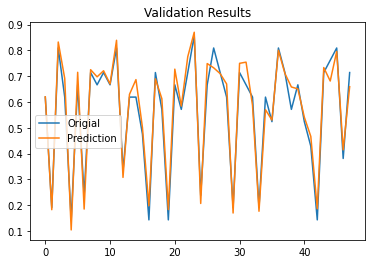

In [ ]:
yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

In [ ]:
yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 5ms/step - loss: 0.0018 - mse: 0.0018
Loss: [0.0018208371475338936, 0.0018208371475338936]
(48,) (48, 1)


2/2 [==============================] - 0s 6ms/step - loss: 0.0012 - mse: 0.0012
Loss: [0.0012381705455482006, 0.0012381705455482006]


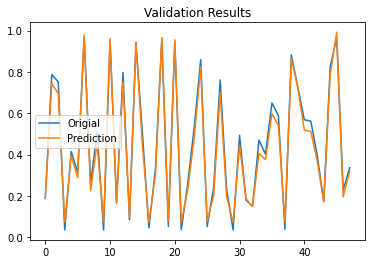

2/2 [==============================] - 0s 7ms/step - loss: 0.0012 - mse: 0.0012
Loss: [0.0012381705455482006, 0.0012381705455482006]
(48,) (48, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 7ms/step - loss: 0.0018 - mse: 0.0018
Loss: [0.0017539915861561894, 0.0017539915861561894]


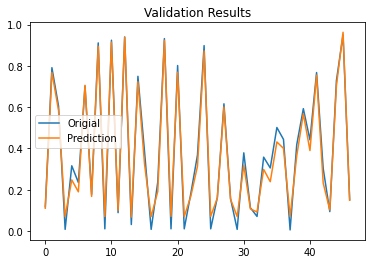

2/2 [==============================] - 0s 5ms/step - loss: 0.0018 - mse: 0.0018
Loss: [0.0017539915861561894, 0.0017539915861561894]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 6ms/step - loss: 0.0027 - mse: 0.0027
Loss: [0.002665275242179632, 0.002665275242179632]


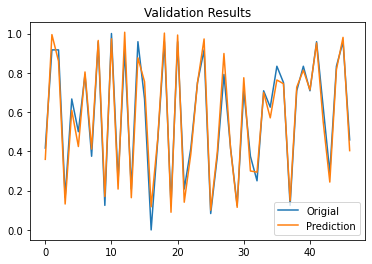

2/2 [==============================] - 0s 9ms/step - loss: 0.0027 - mse: 0.0027
Loss: [0.002665275242179632, 0.002665275242179632]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 6ms/step - loss: 0.0012 - mse: 0.0012
Loss: [0.0011615903349593282, 0.0011615903349593282]


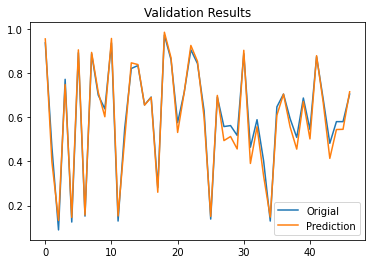

2/2 [==============================] - 0s 7ms/step - loss: 0.0012 - mse: 0.0012
Loss: [0.0011615903349593282, 0.0011615903349593282]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 7ms/step - loss: 0.0038 - mse: 0.0038
Loss: [0.003781064646318555, 0.003781064646318555]


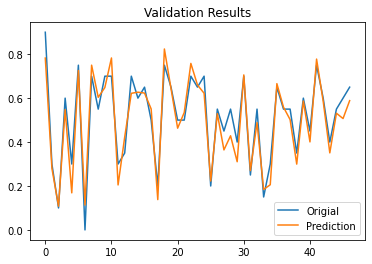

2/2 [==============================] - 0s 6ms/step - loss: 0.0038 - mse: 0.0038
Loss: [0.003781064646318555, 0.003781064646318555]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 5ms/step - loss: 0.0011 - mse: 0.0011
Loss: [0.001115094986744225, 0.001115094986744225]


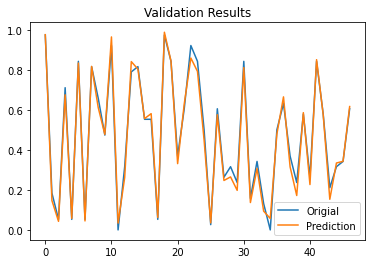

2/2 [==============================] - 0s 6ms/step - loss: 0.0011 - mse: 0.0011
Loss: [0.001115094986744225, 0.001115094986744225]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)

yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)

2/2 [==============================] - 0s 6ms/step - loss: 0.0070 - mse: 0.0070
Loss: [0.007046133745461702, 0.007046133745461702]


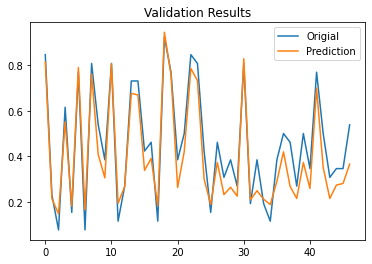

2/2 [==============================] - 0s 7ms/step - loss: 0.0070 - mse: 0.0070
Loss: [0.007046133745461702, 0.007046133745461702]
(47,) (47, 1)


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

test_df = test_df.drop(['CellNo', 'MeasuredDate'], axis=1)

scaler = MinMaxScaler()
scale_cols = ['Volt', 'Temp', 'Resistance']
test_df_scaled = scaler.fit_transform(test_df[scale_cols])

test_df_scaled = pd.DataFrame(test_df_scaled)
test_df_scaled.columns = scale_cols

test = test_df_scaled
feature_cols = ['Volt', 'Temp', 'Resistance']
label_cols = ['Resistance']


test_feature = test[feature_cols]
test_label = test[label_cols]

test_feature, test_label = make_dataset(test_feature, test_label, 20)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(test_feature, test_label, test_size=0.2, random_state=42)


yp = model.predict(x_test)
print('Loss:', model.evaluate(x_test, y_test))
plt.plot(y_test, label='Origial')
plt.plot(yp, label='Prediction')
plt.legend(loc=0)
plt.title('Validation Results')
plt.show()

yp = model.predict(x_test).reshape(-1)
print('Loss:', model.evaluate(x_test, y_test))  
print(yp.shape, y_test.shape)